# Task 2: 3D Object pre-processing

In [1]:
import trimesh
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shutil
import subprocess
import pymeshlab

ORIGINAL_SHAPES_PATH = 'test_database'
RESAMPLED_SHAPES_PATH = 'test_resampled_database'

## Step 2.1: Analyzing a single shape

In [8]:
def analyze_shape(filepath):
    '''
    Analyze a 3D shape using Trimesh and return the required information.
    :param filepath: Path to the OBJ file
    '''
    # Load the mesh using Trimesh
    mesh = trimesh.load(filepath)
    
    num_vertices = len(mesh.vertices)  # Number of vertices
    num_faces = len(mesh.faces)  # Number of faces (triangles)
    face_type = "Triangles"  # Face type (triangles by default for OBJ)
    
    # Axis-aligned bounding box (AABB)
    aabb_min, aabb_max = mesh.bounds
    bounding_box = {
        "min_bound": aabb_min.tolist(),  # Min corner of the bounding box
        "max_bound": aabb_max.tolist()   # Max corner of the bounding box
    }

    has_holes = not mesh.is_watertight  # Has holes or not
    outlier_low = True if num_vertices <= 100 or num_faces <= 100 else False  # Low outlier
    outlier_high = True if num_vertices >= 20000 or num_faces >= 20000 else False  # High outlier

    # Return dictionary of extracted data
    return {
        "vertices": num_vertices,
        "faces": num_faces,
        "face_type": face_type,
        "bounding_box": bounding_box,
        "has_holes": has_holes,
        "outlier_low": outlier_low,
        "outlier_high": outlier_high
    }
    

def analyze_database(labeled_db_path):
    '''
    Iteratively analyze all 3D shapes within the database.
    :param labeled_db_path: Path to the root of the labeled database
    '''
    results = []

    for category in os.listdir(labeled_db_path):
        category_path = os.path.join(labeled_db_path, category)

        if os.path.isdir(category_path):
            for shape_file in os.listdir(category_path):
                if shape_file.endswith('.obj'):
                    filepath = os.path.join(category_path, shape_file)
                    shape_info = {}
                    shape_info["file_name"] = shape_file  # Add the filename of the shape
                    shape_info["obj_class"] = category  # Add class (category) of the shape
                    # Analyze each shape
                    shape_info.update(analyze_shape(filepath))
                    shape_info["file_path"] = os.path.join(category_path, shape_file)  # Add class (category) of the shape
                    
                    results.append(shape_info)

    return results


shapes_data = analyze_database("test_database")
shapes_data_df = pd.DataFrame(shapes_data)
shapes_data_df.to_csv("outputs/data/shapes_data_test.csv")
shapes_data_df.head()

,file_name,obj_class,vertices,faces,face_type,bounding_box,has_holes,outlier_low,outlier_high,file_path
0,m1340.obj,AircraftBuoyant,778,1457,Triangles,"{'min_bound': [0.025, 0.025, 0.025], 'max_boun...",True,False,False,test_database\AircraftBuoyant\m1340.obj
1,m1341.obj,AircraftBuoyant,425,824,Triangles,"{'min_bound': [0.025, 0.025, 0.025], 'max_boun...",True,False,False,test_database\AircraftBuoyant\m1341.obj
2,m1342.obj,AircraftBuoyant,1252,2305,Triangles,"{'min_bound': [0.025, 0.025, 0.025], 'max_boun...",True,False,False,test_database\AircraftBuoyant\m1342.obj
3,m1344.obj,AircraftBuoyant,1093,1930,Triangles,"{'min_bound': [0.025, 0.025, 0.025], 'max_boun...",True,False,False,test_database\AircraftBuoyant\m1344.obj
4,m1345.obj,AircraftBuoyant,3174,6000,Triangles,"{'min_bound': [0.025, 0.025, 0.025], 'max_boun...",True,False,False,test_database\AircraftBuoyant\m1345.obj


## Step 2.2: Statistics over the whole database

### 1. Plot data to observe their distribution

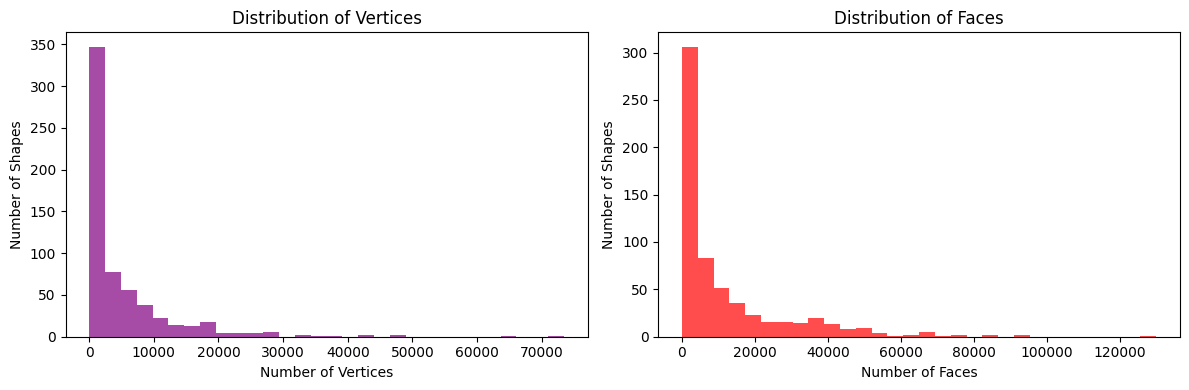

In [9]:
def vertex_face_distribution_plot(shapes_data, vertices, faces):
    plt.figure(figsize=(12, 4))

    # Histogram for vertices
    plt.subplot(1, 2, 1)
    plt.hist(shapes_data[vertices], bins=30, color='purple', alpha=0.7)
    plt.title('Distribution of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Number of Shapes')

    # Histogram for faces
    plt.subplot(1, 2, 2)
    plt.hist(shapes_data[faces], bins=30, color='red', alpha=0.7)
    plt.title('Distribution of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Number of Shapes')

    plt.tight_layout()
    plt.show()

# Load the CSV file
shapes_data_df = pd.read_csv('outputs/data/shapes_data_test.csv')

# Plot data to observe their distribution
vertex_face_distribution_plot(shapes_data_df, 'vertices', 'faces')

### 2. Calculate global statistics

In [5]:
# Compute mean and standard deviation on both vertices and faces
mean_vertices = shapes_data_df['vertices'].mean()
std_vertices = shapes_data_df['vertices'].std()

mean_faces = shapes_data_df['faces'].mean()
std_faces = shapes_data_df['faces'].std()

# Compute other statistics
total_shapes = shapes_data_df.shape[0]
has_holes_count = shapes_data_df[shapes_data_df['has_holes']==True]['has_holes'].count() 
outlier_low_count = shapes_data_df[shapes_data_df['outlier_low']==True]['outlier_low'].count()
outlier_high_count = shapes_data_df[shapes_data_df['outlier_high']==True]['outlier_high'].count()

# Save the data in a csv
global_statistics = {"total_shapes": total_shapes,
                     "mean_vertices": mean_vertices,
                     "std_vertices": std_vertices,
                     "mean_faces": mean_faces,
                     "std_faces": std_faces,
                     "has_holes_count": has_holes_count,
                     "outlier_low_count": outlier_low_count,
                     "outlier_high_count": outlier_high_count,}

pd.DataFrame([global_statistics]).to_csv("outputs/data/global_statistics_test.csv")

# Save list with classes
classes_list = shapes_data_df.obj_class.unique()
with open('outputs/data/classes.txt', 'w') as f:
    for obj_class in classes_list:
        f.write(f"{obj_class}\n")

### 3. Save normal and outlier samples in new folder

In [39]:
# Sample a normal shape from the 'House' category
normal_samples = shapes_data_df[(shapes_data_df['outlier_low'] == False) & (shapes_data_df['obj_class'] == 'House')].sample(n=1)

# Sample 3 outliers from the 'House' category
outlier_samples = shapes_data_df[(shapes_data_df['outlier_low'] == True) & (shapes_data_df['obj_class'] == 'House')].sample(n=3)

# Save the normal and outlier sample paths
normal_sample_paths = normal_samples['file_path'].values
outlier_sample_paths = outlier_samples['file_path'].values

print(f'Normal shapes: {normal_sample_paths}')
print(f'Outlier shapes: {outlier_sample_paths}')

# Copy them from the original directory to a separate directory in the 'outputs' folder
dst = 'outputs/shapes'

for i, src_sample_path in enumerate(normal_sample_paths):
    destination = f'{dst}/normal_{i+1}.obj'
    shutil.copy(src_sample_path, destination)
    
for i, src_sample_path in enumerate(outlier_sample_paths):
    destination = f'{dst}/outlier_{i+1}.obj'
    shutil.copy(src_sample_path, destination)

print('COPIED!')

Normal shapes: ['original_shapes\\House\\m439.obj']
Outlier shapes: ['original_shapes\\House\\m423.obj' 'original_shapes\\House\\m462.obj'
 'original_shapes\\House\\m434.obj']
COPIED!


## Step 2.3. Resampling outliers

### 1. Resample the low outliers and replace the previous file

In [3]:
def isotropic_remesh(mesh):
    '''
    Perform isotropic remeshing on a mesh using PyMeshLab.
    :param mesh: The input mesh (as a Trimesh object)
    :return: Remeshed mesh (as a Trimesh object)
    '''
    # Save the mesh to a temporary file
    temp_input_path = 'temp_input.obj'
    temp_output_path = 'temp_remeshed.obj'
    mesh.export(temp_input_path)

    # Create a new MeshSet
    ms = pymeshlab.MeshSet()
    # Load the mesh
    ms.load_new_mesh(temp_input_path)
    # Apply isotropic remeshing
    target_edge_length = 0.1  # Adjust as needed
    ms.apply_filter('meshing_isotropic_explicit_remeshing',
                    targetlen=pymeshlab.PureValue(target_edge_length),
                    iterations=5)
    # Save the remeshed mesh
    ms.save_current_mesh(temp_output_path)

    # Load the remeshed mesh back into trimesh
    remeshed_mesh = trimesh.load(temp_output_path)

    # Clean up temporary files
    os.remove(temp_input_path)
    os.remove(temp_output_path)

    return remeshed_mesh


def resample_low_outliers(mesh):
    '''
    Use the Catmull-Clark Subdivider to resample low outlier meshes.
    :param mesh: The input mesh (as a Trimesh object)
    :return: Resampled mesh (as a Trimesh object)
    '''
    # Save the mesh to a temporary OFF file
    input_off_file = 'temp_input.off'
    output_off_file = 'temp_output.off'
    mesh.export(input_off_file)

    # Path to the Catmull-Clark subdivider JAR file
    jar_file = 'tools/catmullclark.jar'
    
    if not os.path.isfile(jar_file):
        print(f"Jar file not found at {jar_file}")
        return mesh  # Return the original mesh if the JAR file is missing

    # Command to run the Catmull-Clark subdivision
    cmd = ['java', '-jar', jar_file, input_off_file, output_off_file]

    try:
        # Run the command and capture stdout and stderr
        result = subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

        # Check if output file exists
        if not os.path.isfile(output_off_file):
            print(f"Output file {output_off_file} was not created.")
            return mesh  # Return the original mesh if output file is missing

        # Check if output file is not empty
        if os.path.getsize(output_off_file) == 0:
            print(f"Output file {output_off_file} is empty.")
            return mesh  # Return the original mesh if output file is empty

        # Load the resampled mesh from the output OFF file
        resampled_mesh = trimesh.load(output_off_file)

        # Clean up temporary files
        os.remove(input_off_file)
        os.remove(output_off_file)

        return resampled_mesh

    except subprocess.CalledProcessError as e:
        print(f"Error in subdivision process: {e}")
        print("Subprocess stdout:", e.stdout)
        print("Subprocess stderr:", e.stderr)
        return mesh  # Return the original mesh if the subdivision fails


def simplify_high_complexity_mesh(mesh, target_percentage=0.65):
    '''
    Simplifies a mesh with a high number of edges using PyMeshLab's Quadric Edge Collapse Decimation.
    :param mesh: The input mesh (as a Trimesh object)
    :param target_percentage: The target size as a percentage of the original (0 < target_percentage <= 1).
    :return: Simplified mesh (as a Trimesh object)
    '''
    temp_input_path = 'temp_input.obj'
    temp_output_path = 'temp_simplified.obj'
    mesh.export(temp_input_path)

    ms = pymeshlab.MeshSet()
    ms.load_new_mesh(temp_input_path)

    try:
        # Apply Quadric Edge Collapse Decimation to simplify the mesh
        ms.apply_filter('meshing_decimation_quadric_edge_collapse', targetperc=target_percentage)

        # Save the simplified mesh
        ms.save_current_mesh(temp_output_path)

        # Load the simplified mesh back into Trimesh
        simplified_mesh = trimesh.load(temp_output_path)

    except pymeshlab.PyMeshLabException as e:
        print(f"Error during mesh simplification: {e}")
        return mesh  # Return original mesh if the filter fails

    os.remove(temp_input_path)
    os.remove(temp_output_path)

    return simplified_mesh

    
def process_meshes(df, resampled_root):
    '''
    Apply isotropic remeshing to all meshes and Catmull-Clark subdivision to low outliers.
    :param df: DataFrame containing shape metadata (shapes_data_df)
    :param resampled_root: Path to the resampled database folder (e.g., 'resampled_shapes')
    '''
    for index, row in df.iterrows():
        obj_class = row['obj_class']
        file_name = row['file_name']
        file_path = row['file_path']
        
        # Construct the path to the file in the resampled folder
        resampled_file_path = os.path.join(resampled_root, obj_class, file_name)

        # Load the mesh
        mesh = trimesh.load(file_path)

        

        # For low outliers, apply Catmull-Clark subdivision
        if row['outlier_low']:
            # Apply isotropic remeshing 
            print(f"Applying isotropic remeshing to {file_name}")
            remeshed_mesh = isotropic_remesh(mesh)
        
            print(f"Applying Catmull-Clark subdivision to {file_name} (low outlier)")
            resampled_mesh = resample_low_outliers(remeshed_mesh)
        elif row['outlier_high']:
            print(f"Applying isotropic remeshing to {file_name}")
            remeshed_mesh = isotropic_remesh(mesh)
            resampled_mesh = remeshed_mesh
        else:
            print(f"Applying isotropic remeshing to {file_name}")
            remeshed_mesh = isotropic_remesh(mesh)
            resampled_mesh = remeshed_mesh

        # Ensure the directory exists
        os.makedirs(os.path.dirname(resampled_file_path), exist_ok=True)

        # Save the resampled file in the resampled folder
        resampled_mesh.export(resampled_file_path)
  

shapes_data_df = pd.read_csv('outputs/data/shapes_data_test.csv')
# Example usage after you manually copy the database
process_meshes(shapes_data_df, RESAMPLED_SHAPES_PATH)


Applying isotropic remeshing to m1340.obj
Applying isotropic remeshing to m1341.obj
Applying isotropic remeshing to m1342.obj
Applying isotropic remeshing to m1344.obj
Applying isotropic remeshing to m1345.obj
Applying isotropic remeshing to m1347.obj
Applying isotropic remeshing to m1348.obj
Applying isotropic remeshing to D00086.obj
Applying isotropic remeshing to D00138.obj
Applying isotropic remeshing to D00310.obj
Applying isotropic remeshing to D00348.obj
Applying isotropic remeshing to D00651.obj
Applying isotropic remeshing to D00780.obj
Applying isotropic remeshing to D00792.obj
Applying isotropic remeshing to D00869.obj
Applying isotropic remeshing to D00953.obj
Applying isotropic remeshing to m465.obj
Applying isotropic remeshing to m57.obj
Applying isotropic remeshing to m58.obj
Applying isotropic remeshing to m65.obj
Applying isotropic remeshing to m67.obj
Applying isotropic remeshing to m70.obj
Applying isotropic remeshing to m74.obj
Applying isotropic remeshing to m76.ob

### 2. Keep a before-resampling and after-resampling for visualization

In [10]:
dst = 'outputs/shapes'

# Select a random non-outlier shape from the 'House' category
outlier_before_path = shapes_data_df[(shapes_data_df['outlier_low'] == True) & 
                                     (shapes_data_df['obj_class'] == 'House')].sample(n=1)['file_path'].values[0]

# Construct the path for the resampled shape
outlier_after_path = os.path.join(RESAMPLED_SHAPES_PATH, 
                                  os.path.relpath(outlier_before_path, start='original_shapes'))

# Ensure the output folder exists
os.makedirs(dst, exist_ok=True)

# Save the before resampling file
destination_before_resampling = os.path.join(dst, 'before_resampling.obj')
shutil.copy(outlier_before_path, destination_before_resampling)

# Save the after resampling file
destination_after_resampling = os.path.join(dst, 'after_resampling.obj')
shutil.copy(outlier_after_path, destination_after_resampling)

'outputs/shapes\\after_resampling.obj'